In [2]:
import math
import json
import pandas as pd
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [91]:
def calc_cost(distance):
    """
    determine the cost of the movement according to the rules:
    Each swing costs the particle $D^-2, where D is the straight-line distance of the length of rope used for that particular swing.
    """
    return pow(distance, -2)

def calc_distance(x1,y1,x2,y2): 
    """
    determine the distance between 2 points on a coordinate plane
    """
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calc_slope(x1,y1,x2,y2):
    ##(0,0) => (5,0)
    if x1 == x2 and y1 == y2:
        return "NaL"
    elif x1 == x2:
        if y1 < y2:
            return "vertical_pos"
        elif y1 > y2:
            return "vertical_neg"
    elif y1 == y2:
        if x1 < x2:
            return "horizontal_pos"
        elif x1 > x2:
            return "horizontal_neg"
    else:
#         if slope > 0:
#             return str(slope)+"_pos"
#         elif slope < 0:
#             return str(slope)+"_neg"
        slope = (y2-y1)/(x2-x1)
    
    return str(slope)+"_"+quandrant_loc(x1,y1,x2,y2)
    
def plot_path(x1,y1,x2,y2, color="b"):
    # plot points
    ax.plot(x1, y1, color+'o')
    ax.plot(x2, y2, color+'o')
    # plot line
    ax.plot([x1, x2],[y1, y2], color+'-')

def lattice_intercepts(origin, radius):
    x = origin[0]
    y = origin[1]
    r_2 = round(pow(radius,2),1) # rounding to nearest 10th...
    xy_2 = (pow(x,2) + pow(y,2))
    lattice_intercepts = []
    i = 0
    while i <= xy_2:
        j = 0
        while j <= xy_2:
#             print(str(pow((i - x),2) + pow((j - y),2))+" == "+str(r_2))
            if (pow((i - x),2) + pow((j - y),2) == r_2):
                lattice_intercepts.append((i,j))
            j = j + 1
        i = i + 1
    return lattice_intercepts

def calc_angle(p0, p1, p2):
    """
    calculate the angle (in degrees) for vertex p0 p1 p2 
    """
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p2) - np.array(p1)
    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return round(np.degrees(angle),4)

def inbounds(origin, thru_pt, distance, slope, angle=None):

    x = origin[0]
    y = origin[1]
    x_tp = thru_pt[0]
    y_tp = thru_pt[1]
    
    inbounds = True

    if slope == "vertical_pos":
        x1 = x
        y1 = y + distance
        if y1 > 20.5:
            inbounds = False
    elif slope == "vertical_neg":
        x1 = x
        y1 = y - distance
        if y1 < 0.5:
            inbounds = False
    elif slope == "horizontal_pos":
        x1 = x + distance
        y1 = y
        if x1 > 20.5:
            inbounds = False
    elif slope == "horizontal_neg":
        x1 = x - distance
        y1 = y
        if x1 < 0.5:
            inbounds = False
    else:
        slope = float(slope.split("_")[0])
        c = 1/math.sqrt(1+pow(slope,2))
        s = slope/math.sqrt(1+pow(slope,2))

        # QUADRANT 1
        if x < x_tp and y < y_tp:
            x1 = (x+distance*c)
            y1 = (y+distance*s)
        # QUADRANT 2
        elif x < x_tp and y > y_tp:
            x1 = (x+distance*c)
            y1 = (y+distance*s)
        # QUADRANT 3
        elif x > x_tp and y > y_tp:
            x1 = (x-distance*c)
            y1 = (y-distance*s)
        # QUADRANT 4
        elif x > x_tp and y < y_tp:
            x1 = (x-distance*c)
            y1 = (y-distance*s)

        if x1 < 0.5 or x1 > 20.5 or y1 < 0.5 or y1 > 20.5:
            inbounds = False
            
    if inbounds:        
        plot_path(x,y,x1,y1,"y")
        plot_path(x,y,x_tp,y_tp,"c")
    
    return inbounds

def quandrant_loc(x,y,x1,y1):
    # QUADRANT 1
    if x < x1 and y < y1:
        return "q1"
    # QUADRANT 2
    elif x < x1 and y > y1:
        return "q2"
    # QUADRANT 3
    elif x > x1 and y > y1:
        return "q3"
    # QUADRANT 4
    elif x > x1 and y < y1:
        return "q4"

def recursive_swing(toss,start,v,graph,df,coords,og_post=None):
#     print(">>> START RECURSION!")
#     print(v)
#     print(len(coords))
#     print(df)
    g = 180
    d_rem = 0
    stack = (0,0,0,0,0)
    c = calc_cost(calc_distance(toss[0],toss[1],start[0],start[1]))
    
    for i in graph[(start[0],start[1])]:
        # make sure radius of swing long enough to catch a post and that it doesn't catch the origin
        if start[2] > i[2] and (start[0],start[1]) != (i[0],i[1]):
            g_2 = calc_angle((toss[0],toss[1]),(start[0],start[1]),(i[0],i[1]))
            if v == "pos":
                if g_2 < g: 
                    g = g_2
                    d_rem = start[2] - i[2]
                    stack = (i[0],i[1],d_rem,i[3],g_2)
            if v == "neg":
                g = g*-1
                if g_2 > g: 
                    g = g_2
                    d_rem = start[2] - i[2]
                    stack = (i[0],i[1],d_rem,i[3],g_2)
                    
    test_graph = [(i[0],i[1]) for i in graph[(start[0],start[1])]]

    # find all the lps
    if stack != (0,0,0,0,0) and inbounds((toss[0],toss[1]), (start[0],start[1]), start[2], calc_slope(toss[0],toss[1],start[0],start[1])):
        
        lps = lattice_intercepts((stack[0],stack[1]),stack[2]) 
        if len(lps) > 0:
            for l in lps:
#                 print("has lps")
                x = l[0]
                y = l[1]
                if (x,y) not in test_graph:
                    g_bound = calc_angle((toss[0],toss[1]),(start[0],start[1]),(stack[0],stack[1]))
                    g_swing = calc_angle((toss[0],toss[1]),(start[0],start[1]),(x,y))
    #                 print("angle: "+str(180-abs(g5)))
    #                 print("test: "+str(g_test))
                    if v == "pos":
                        if g_swing >= g_bound:
    #                         print(str((x,y)))
    #                         print("g_bound: ("+str((toss[0],toss[1]))+","+str((start[0],start[1]))+","+str((stack[0],stack[1]))+") | "+str(g_bound))
    #                         print("g_swing: ("+str((toss[0],toss[1]))+","+str((start[0],start[1]))+","+str((x,y))+") | "+str(g_swing))

                            ax.plot(x,y,'mo')
    #                         plot_path(start[0],start[1],stack[0],stack[1],"c")
                            new_coords = coords[:]
                            new_coords.append((x,y))
                            if og_post:
                                new_coords.remove((og_post[0],og_post[1]))
                                df.loc[len(df)] = [(excel_col(int(og_post[0]))+str(int(og_post[1])),excel_col(x)+str(y)), c, new_coords]
                            else:
                                new_coords.remove((start[0],start[1]))
                                df.loc[len(df)] = [(excel_col(int(start[0]))+str(int(start[1])),excel_col(x)+str(y)), c, new_coords]

                    if v == "neg": 
                        if g_swing <= g_bound:
    #                         print(str((x,y)))
    #                         print("g_bound: ("+str((toss[0],toss[1]))+","+str((start[0],start[1]))+","+str((stack[0],stack[1]))+") | "+str(g_bound))
    #                         print("g_swing: ("+str((toss[0],toss[1]))+","+str((start[0],start[1]))+","+str((x,y))+") | "+str(g_swing))
                            ax.plot(x,y,'mo')
    #                         plot_path(start[0],start[1],stack[0],stack[1],"c")
                            new_coords = coords[:]

                            new_coords.append((x,y))
                            if og_post:
                                new_coords.remove((og_post[0],og_post[1]))
                                df.loc[len(df)] = [(excel_col(int(og_post[0]))+str(int(og_post[1])),excel_col(x)+str(y)), c, new_coords]
                            else:
                                new_coords.remove((start[0],start[1]))
                                df.loc[len(df)] = [(excel_col(int(start[0]))+str(int(start[1])),excel_col(x)+str(y)), c, new_coords]

            # see if there is more slack...
            if stack[2] > 0:
                if og_post:
                    return recursive_swing(start,stack,v,graph,df,coords,og_post)
                else:
                    return recursive_swing(start,stack,v,graph,df,coords)
            else:
                return df
        else:
            return df
    else:
        return df
    
def excel_col(col):
    quot, rem = divmod(col-1,26)
    return excel_col(quot) + chr(rem+ord("A")) if col!=0 else ""


def build_graph(coords):
    graph = {}
    for i in range(len(coords)):
        x1 = coords[i][0]
        y1 = coords[i][1]
        # first toss START
        # x1 = 0
        # y1 = 0
        viable_toss_stack = {}
        toss = []
        toss_length = 0
        for j in coords:
            x2 = j[0]
            y2 = j[1]
            distance = calc_distance(x1,y1,x2,y2)
            slope = calc_slope(x1,y1,x2,y2)
            if slope not in viable_toss_stack:
                viable_toss_stack[slope] = (x2,y2,distance,slope)
            else:
                if abs(viable_toss_stack[slope][2]) > abs(distance):
                    del viable_toss_stack[slope]
                    viable_toss_stack[slope] = (x2,y2,distance,slope)
                elif abs(viable_toss_stack[slope][2]) == abs(distance):
                    viable_toss_stack[slope] = (x2,y2,distance,slope)             


        for k in viable_toss_stack:
            toss.append((viable_toss_stack[k][0], viable_toss_stack[k][1], viable_toss_stack[k][2], viable_toss_stack[k][3]))
            # toss.append((viable_toss_stack[k][0], viable_toss_stack[k][1]))
            graph[(x1,y1)] = toss
    return graph

toss: (1.0,1.0) => (3.0,20.0) | d:19.1049731745428 | s:9.5_q1
    g_pos_swing: (3.0,20.0) => (4.0,11.0) | d:10.049588036405382 | s:-9.0_q2 | g:12.3492°
    g_neg_swing: (3.0,20.0) => (1.0,11.0) | d:9.885428717249912 | s:4.5_q3 | g:-6.5198°
    d2: 19.1049731745428
    lps: [(1, 1), (1, 39), (5, 1), (5, 39), (16, 6), (16, 34), (17, 7), (17, 33), (22, 18), (22, 22)]
___________
        positive swing possibilities:
toss: (1.0,1.0) => (5.0,20.0) | d:19.4164878389476 | s:4.75_q1
    g_pos_swing: (5.0,20.0) => (4.0,11.0) | d:10.361102700810182 | s:9.0_q3 | g:5.5485°
    g_neg_swing: (5.0,20.0) => (4.0,16.0) | d:15.293382213329938 | s:4.0_q3 | g:-2.1476°
    d2: 19.4164878389476
    lps: [(1, 1), (1, 39), (9, 1), (9, 39), (16, 4), (16, 36), (21, 9), (21, 31), (24, 16), (24, 24)]
___________
        positive swing possibilities:
toss: (1.0,1.0) => (11.0,20.0) | d:21.470910553583888 | s:1.9_q1
    g_pos_swing: (11.0,20.0) => (5.0,8.0) | d:8.05450268858515 | s:2.0_q3 | g:1.1935°
    g_neg_swing

    g_pos_swing: (16.0,13.0) => (6.0,1.0) | d:3.5888733604852376 | s:1.2_q3 | g:11.5346°
    g_neg_swing: (16.0,13.0) => (8.0,8.0) | d:9.775391580241942 | s:0.625_q3 | g:-6.6544°
    d2: 19.209372712298546
    lps: [(1, 1), (1, 25), (4, 28), (28, 28), (31, 1), (31, 25)]
___________
toss: (1.0,1.0) => (19.0,13.0) | d:21.633307652783937 | s:0.6666666666666666_q1
    g_pos_swing: (19.0,13.0) => (12.0,7.0) | d:12.41376319549105 | s:0.8571428571428571_q3 | g:6.9112°
    g_neg_swing: (19.0,13.0) => (8.0,8.0) | d:9.550261679189365 | s:0.45454545454545453_q3 | g:-9.2461°
    d2: 21.633307652783937
    lps: [(1, 1), (1, 25), (7, 31), (31, 31), (37, 1), (37, 25)]
___________
toss: (1.0,1.0) => (20.0,12.0) | d:21.95449840010015 | s:0.5789473684210527_q1
    g_pos_swing: (20.0,12.0) => (12.0,7.0) | d:12.520517268043546 | s:0.625_q3 | g:1.9368°
    g_neg_swing: (20.0,12.0) => (8.0,8.0) | d:9.305387759426631 | s:0.3333333333333333_q3 | g:-11.6336°
    d2: 21.95449840010015
    lps: [(1, 1), (1, 23),

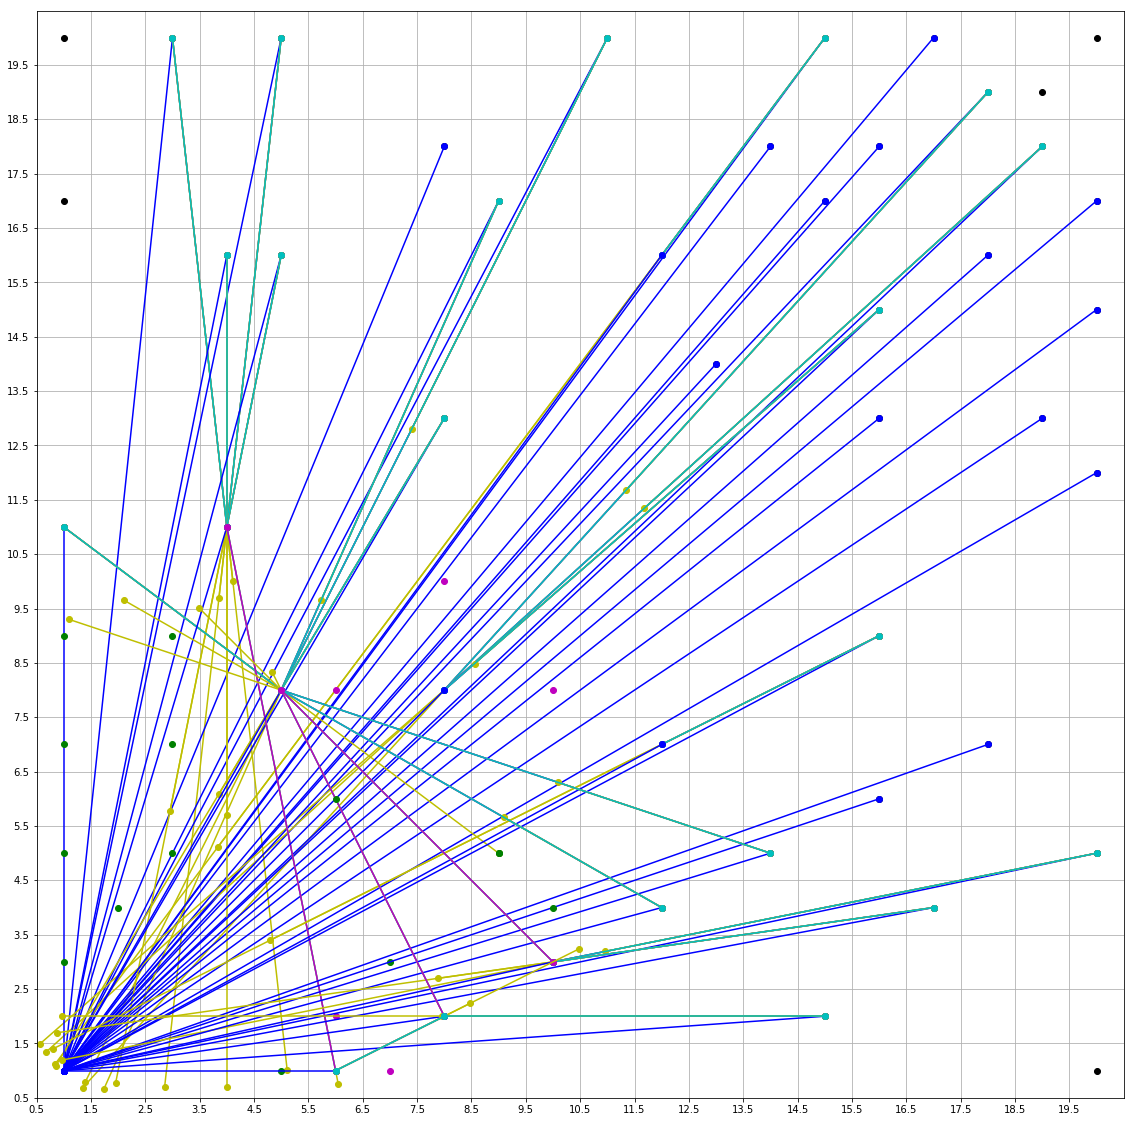

In [95]:
# q1
# coords = [(4.0, 12.0),(9.0, 7.0), (6.0, 4.0), (7.0, 3.0)]
# q2
# coords = [(4.0, 1.0),(6.0, 9.0),(7.0, 10.0),(9.0, 6.0)]
# q3
# coords = [(9.0, 1.0),(4.0, 6.0), (7.0, 9.0), (6.0, 10.0)]
# q4
# coords = [(9.0, 12.0),(4.0, 7.0), (7.0, 4.0), (6.0, 3.0)]

coords = [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, 20.0), (15.0, 20.0), (17.0, 20.0), (20.0, 20.0), (18.0, 19.0), (19.0, 19.0), (8.0, 18.0), (14.0, 18.0), (16.0, 18.0), (19.0, 18.0), (1.0, 17.0), (9.0, 17.0), (15.0, 17.0), (20.0, 17.0), (4.0, 16.0), (5.0, 16.0), (12.0, 16.0), (18.0, 16.0), (16.0, 15.0), (20.0, 15.0), (13.0, 14.0), (8.0, 13.0), (16.0, 13.0), (19.0, 13.0), (20.0, 12.0), (1.0, 11.0), (4.0, 11.0), (16.0, 9.0), (5.0, 8.0), (8.0, 8.0), (12.0, 7.0), (18.0, 7.0), (16.0, 6.0), (14.0, 5.0), (20.0, 5.0), (12.0, 4.0), (17.0, 4.0), (10.0, 3.0), (8.0, 2.0), (15.0, 2.0), (1.0, 20.0), (6.0, 1.0), (20.0, 1.0)]

move_df = pd.DataFrame(columns=["move_notational","move_coords","cost","graph_coords"])

# graph properties
# figure(figsize=(12,12))
# ax=subplot(aspect='equal')
# xlim(.5,12.5)
# ylim(.5,12.5)
# ax.set_xticks(np.arange(.5, 12.5, 1))
# ax.set_yticks(np.arange(.5, 12.5, 1))
figure(figsize=(20,20))
ax=subplot(aspect='equal')
xlim(.5,20.5)
ylim(.5,20.5)
ax.set_xticks(np.arange(.5, 20.5, 1))
ax.set_yticks(np.arange(.5, 20.5, 1))
# plot all coordinates
[ax.plot(i[0], i[1], 'ko') for i in coords]


gr = build_graph(coords)


# graph search loop
# FIND EVERY FIRST MOVE Landing Point!
for i in gr:
    x1 = i[0]
    y1 = i[1]
    for j in gr[i]:
        x2 = j[0]
        y2 = j[1]
        d2 = j[2]
        s2 = j[3]
        
        g_pos = 180
        d_pos_rem = 0
        g_pos_stack = (0,0,0,0,0)

        g_neg = -180
        d_neg_rem = 0
        g_neg_stack = (0,0,0,0,0)
#         if x1 == 1 and y1 == 1 and x2 == 3.0 and y2 == 20.0: 
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 11.0 and y2 == 20.0: # recursive swing goes OB # manual removal
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 20.0: #WHAT?
#         if x1 == 1 and y1 == 1 and x2 == 17.0 and y2 == 20.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 19.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 14.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 18.0:
#         if x1 == 1 and y1 == 1 and x2 == 19.0 and y2 == 18.0: #WHAT?
#         if x1 == 1 and y1 == 1 and x2 == 9.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 17.0:
#         if x1 == 1 and y1 == 1 and x2 == 4.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 16.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 15.0: # WHAT?!
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 15.0:
#         if x1 == 1 and y1 == 1 and x2 == 13.0 and y2 == 14.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 13.0: # recursive_swing goes OB
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 13.0:
#         if x1 == 1 and y1 == 1 and x2 == 19.0 and y2 == 13.0:
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 12.0:
#         if x1 == 1 and y1 == 1 and x2 == 1.0 and y2 == 11.0:
#         if x1 == 1 and y1 == 1 and x2 == 4.0 and y2 == 11.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 9.0: #WHAT?
#         if x1 == 1 and y1 == 1 and x2 == 5.0 and y2 == 8.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 8.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 7.0:
#         if x1 == 1 and y1 == 1 and x2 == 18.0 and y2 == 7.0:
#         if x1 == 1 and y1 == 1 and x2 == 16.0 and y2 == 6.0:
#         if x1 == 1 and y1 == 1 and x2 == 14.0 and y2 == 5.0: # goes OB but isn't marked as OB
#         if x1 == 1 and y1 == 1 and x2 == 20.0 and y2 == 5.0:
#         if x1 == 1 and y1 == 1 and x2 == 12.0 and y2 == 4.0:
#         if x1 == 1 and y1 == 1 and x2 == 17.0 and y2 == 4.0:
#         if x1 == 1 and y1 == 1 and x2 == 10.0 and y2 == 3.0:
#         if x1 == 1 and y1 == 1 and x2 == 8.0 and y2 == 2.0:
#         if x1 == 1 and y1 == 1 and x2 == 15.0 and y2 == 2.0:
#         if x1 == 1 and y1 == 1 and x2 == 6.0 and y2 == 1.0:
        if x1 == 1 and y1 == 1:
            if (x1,y1) != (x2,y2) and s2 != "NaL":
                print("toss: ("+str(x1)+","+str(y1)+") => ("+str(x2)+","+str(y2)+") | d:"+str(d2)+" | s:"+str(s2))
                for k in gr[(x2,y2)]:
                    x3 = k[0]
                    y3 = k[1]
                    d3 = k[2]
                    s3 = k[3]
                    g = calc_angle((x1,y1),(x2,y2),(x3,y3))
                    
                    if d3 < d2 and s3 != "NaL":

                        if 0 < g < g_pos:
                            g_pos = g
                            d_pos_rem = d2 - d3
                            g_pos_stack = (x3,y3,d_pos_rem,s3,g)
                        elif 0 > g > g_neg:
                            g_neg = g
                            d_neg_rem = d2 - d3
                            g_neg_stack = (x3,y3,d_neg_rem,s3,g)
#                         print("    swing: ("+str(x2)+","+str(y2)+") => ("+str(x3)+","+str(y3)+") | d:"+str(d3)+" | g:"+str(g)+"\u00B0"+" | s:"+str(s3))
                
                lps = lattice_intercepts((x2,y2), d2)
            
                print("    g_pos_swing: ("+str(x2)+","+str(y2)+") => ("+str(g_pos_stack[0])+","+str(g_pos_stack[1])+") | d:"+str(g_pos_stack[2])+" | s:"+str(g_pos_stack[3])+" | g:"+str(g_pos_stack[4])+"\u00B0")
#                 ax.plot(g_pos_stack[0],g_pos_stack[1], 'go')
                print("    g_neg_swing: ("+str(x2)+","+str(y2)+") => ("+str(g_neg_stack[0])+","+str(g_neg_stack[1])+") | d:"+str(g_neg_stack[2])+" | s:"+str(g_neg_stack[3])+" | g:"+str(g_neg_stack[4])+"\u00B0")
#                 ax.plot(g_neg_stack[0],g_neg_stack[1], 'go')
#                 print("    x2: "+str(x2))
#                 print("    y2: "+str(y2))
                print("    d2: "+str(d2))
                print("    lps: "+str(lps))
                print("___________")

                plot_path(x1,y1,x2,y2,"b")
                
                
                # positive swing possibilities 
#                 print(">>> p (x2,y2): "+str((x2,y2)))
#                 print(">>> p distance: "+str(d2))
#                 print(">>> p slope: "+str(g_pos_stack[3]))
                if g_pos_stack != (0,0,0,0,0) and inbounds((x2,y2), (g_pos_stack[0],g_pos_stack[1]), d2, calc_slope(x2,y2,g_pos_stack[0],g_pos_stack[1])):
                    plot_path(x2,y2,g_pos_stack[0],g_pos_stack[1],"m")
                    g_p = g_pos_stack[4]
                    for l in lps:
                        x4_p = l[0]
                        y4_p = l[1]
                        g2_p = calc_angle((x1,y1),(x2,y2),(x4_p,y4_p))
#                         print("        pt1_p: "+str([(x1,y1),(x2,y2),(x4_p,y4_p)])+" |"+str(g2_p) + " < " + str(g_p))
                        if 0 <= g2_p <= g_p and (x4_p,y4_p) != (x1,y1):
                            ax.plot(x4_p,y4_p, 'go')
                            new_coords_pos = coords[:]
                            new_coords_pos.remove((x2,y2))
                            new_coords_pos.append((x4_p,y4_p))
                            move_df.loc[len(move_df)] = [(excel_col(int(x2))+str(int(y2)),excel_col(x4_p)+str(y4_p)), calc_cost(d2), new_coords_pos]
                   
                    # recursive search until rope runs out...
                    # recursive_swing((x2,y2),(g_pos_stack[0],g_pos_stack[1]))
                    print("        positive swing possibilities:")
                    move_df = recursive_swing((x2,y2),g_pos_stack,"pos",gr,move_df,coords,(x2,y2))
                              
                # negative swing possibilities
#                 print(">>> n (x2,y2): "+str((x2,y2)))
#                 print(">>> n distance: "+str(d2))
#                 print(">>> n slope: "+str(g_neg_stack[3]))
                if g_neg_stack != (0,0,0,0,0) and inbounds((x2,y2), (g_neg_stack[0],g_neg_stack[1]), d2, calc_slope(x2,y2,g_neg_stack[0],g_neg_stack[1])):
                    plot_path(x2,y2,g_neg_stack[0],g_neg_stack[1],"m")
                    g_n = g_neg_stack[4]
                    for l in lps:
                        x4_n = l[0]
                        y4_n = l[1]
                        g2_n = calc_angle((x1,y1),(x2,y2),(x4_n,y4_n))
#                         print("        pt1_n: "+str([(x1,y1),(x2,y2),(x4_n,y4_n)])+" |"+str(g2_n) + " > " + str(g_n))
                        if 0 >= g2_n >= g_n and (x4_n,y4_n) != (x1,y1):
                            ax.plot(x4_n,y4_n, 'go')
                            new_coords_neg = coords[:]
                            new_coords_neg.remove((x2,y2))
                            new_coords_neg.append((x4_n,y4_n))
                            move_df.loc[len(move_df)] = [(excel_col(int(x2))+str(int(y2)),excel_col(x4_n)+str(y4_n)), calc_cost(d2), new_coords_neg]
                            
            
                    # recursive search until rope runs out...
                    print("        negative swing possibilities:")
                    move_df = recursive_swing((x2,y2),g_neg_stack,"neg",gr,move_df,coords,(x2,y2))

                                  
plt.grid()
print(move_df)
# move_df.to_csv("/Users/jnielsen/Desktop/move1.0.csv")

In [81]:

print(calc_distance(8,2,1,1))
print(calc_distance(8,2,5,8))
print(calc_distance(1,1,12,4)-calc_distance(12,4,.5,4))

# print(excel_col(20))

7.0710678118654755
6.708203932499369
-0.09824574900862082


In [94]:
print(move_df)


# for index, row in move_df.iterrows():
#     print(row['move1'], row['cost'], row['coords'])

         move1      cost                                             coords
0    (C20, E1)  0.002740  [(1.0, 1.0), (5.0, 20.0), (11.0, 20.0), (15.0,...
1    (K20, F2)  0.005556  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (15.0, ...
2    (K20, G1)  0.005556  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (15.0, ...
3    (A11, G3)  0.010000  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
4    (A11, I5)  0.010000  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
5    (A11, F8)  0.040000  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
6   (A11, H10)  0.040000  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
7    (A11, J8)  0.040000  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
8     (N5, A9)  0.005405  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
9     (L4, A7)  0.007692  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
10    (J3, A5)  0.011765  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
11    (J3, C9)  0.011765  [(1.0, 1.0), (3.0, 20.0), (5.0, 20.0), (11.0, ...
12    (H2, A

In [108]:
move1_df = pd.read_csv("/Users/jnielsen/Desktop/move1.0.csv")
print(move1_df)

    Unnamed: 0           move1    cost  \
0            0   ('C20', 'E1')  0.0027   
1            1   ('A11', 'G3')  0.0100   
2            2   ('A11', 'I5')  0.0100   
3            3   ('A11', 'F8')  0.0400   
4            4  ('A11', 'H10')  0.0400   
5            5   ('A11', 'J8')  0.0400   
6            6    ('L4', 'A7')  0.0077   
7            7    ('J3', 'A5')  0.0118   
8            8    ('J3', 'C9')  0.0118   
9            9    ('H2', 'A3')  0.0200   
10          10    ('H2', 'C7')  0.0200   
11          11    ('F1', 'B4')  0.0400   
12          12    ('F1', 'C5')  0.0400   
13          13    ('F1', 'F6')  0.0400   
14          14    ('F1', 'I5')  0.0400   
15          15    ('F1', 'J4')  0.0400   

                                               coords  
0   [(5.0, 20.0), (11.0, 20.0), (15.0, 20.0), (17....  
1   [(3.0, 20.0), (5.0, 20.0), (11.0, 20.0), (15.0...  
2   [(3.0, 20.0), (5.0, 20.0), (11.0, 20.0), (15.0...  
3   [(3.0, 20.0), (5.0, 20.0), (11.0, 20.0), (15.0...  
4   [

In [110]:
coords_1 = move1_df.loc[0]["coords"]
print(coords_1)

[(5.0, 20.0), (11.0, 20.0), (15.0, 20.0), (17.0, 20.0), (20.0, 20.0), (18.0, 19.0), (19.0, 19.0), (8.0, 18.0), (14.0, 18.0), (16.0, 18.0), (19.0, 18.0), (1.0, 17.0), (9.0, 17.0), (15.0, 17.0), (20.0, 17.0), (4.0, 16.0), (5.0, 16.0), (12.0, 16.0), (18.0, 16.0), (16.0, 15.0), (20.0, 15.0), (13.0, 14.0), (8.0, 13.0), (16.0, 13.0), (19.0, 13.0), (20.0, 12.0), (1.0, 11.0), (4.0, 11.0), (16.0, 9.0), (5.0, 8.0), (8.0, 8.0), (12.0, 7.0), (18.0, 7.0), (16.0, 6.0), (14.0, 5.0), (20.0, 5.0), (12.0, 4.0), (17.0, 4.0), (10.0, 3.0), (8.0, 2.0), (15.0, 2.0), (1.0, 20.0), (6.0, 1.0), (20.0, 1.0), (5, 1)]
